In [3]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = (12, 10)
# supress versioning warnings of keras
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

charging_data = pd.read_pickle(os.path.join('..', 'Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('..', 'Data', 'weather_data.pkl'))

agg_charging_data = pd.read_pickle(os.path.join('..', 'Data', 'aggregated_data.pkl'))
agg_charging_data['year'] = agg_charging_data.index.year

#print(agg_charging_data.head(), '\n Data Types: \n',agg_charging_data.dtypes )
print(agg_charging_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29717 entries, 2018-04-25 04:00:00-07:00 to 2021-09-14 08:00:00-07:00
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   activeSessions_site2     29717 non-null  int64  
 1   utilizationRate_site2    29717 non-null  float64
 2   kWhDelivered_site2       29717 non-null  float64
 3   idleRate_site2           29717 non-null  float64
 4   blockedRate_site2        29717 non-null  float64
 5   activeSessions_site1     29717 non-null  int64  
 6   utilizationRate_site1    29717 non-null  float64
 7   kWhDelivered_site1       29717 non-null  float64
 8   idleRate_site1           29717 non-null  float64
 9   blockedRate_site1        29717 non-null  float64
 10  activeSessions_total     29717 non-null  int64  
 11  kWhDelivered_total       29717 non-null  float64
 12  utilizationRate_total    29717 non-null  float64
 13  idleRate_total           2971

                     utilizationRate_total
start_hour                                
2021-01-01 00:00:00               0.002005
2021-01-01 01:00:00               0.002005
2021-01-01 02:00:00               0.002005
2021-01-01 03:00:00               0.002005
2021-01-01 04:00:00               0.002005
0
(6152, 1)


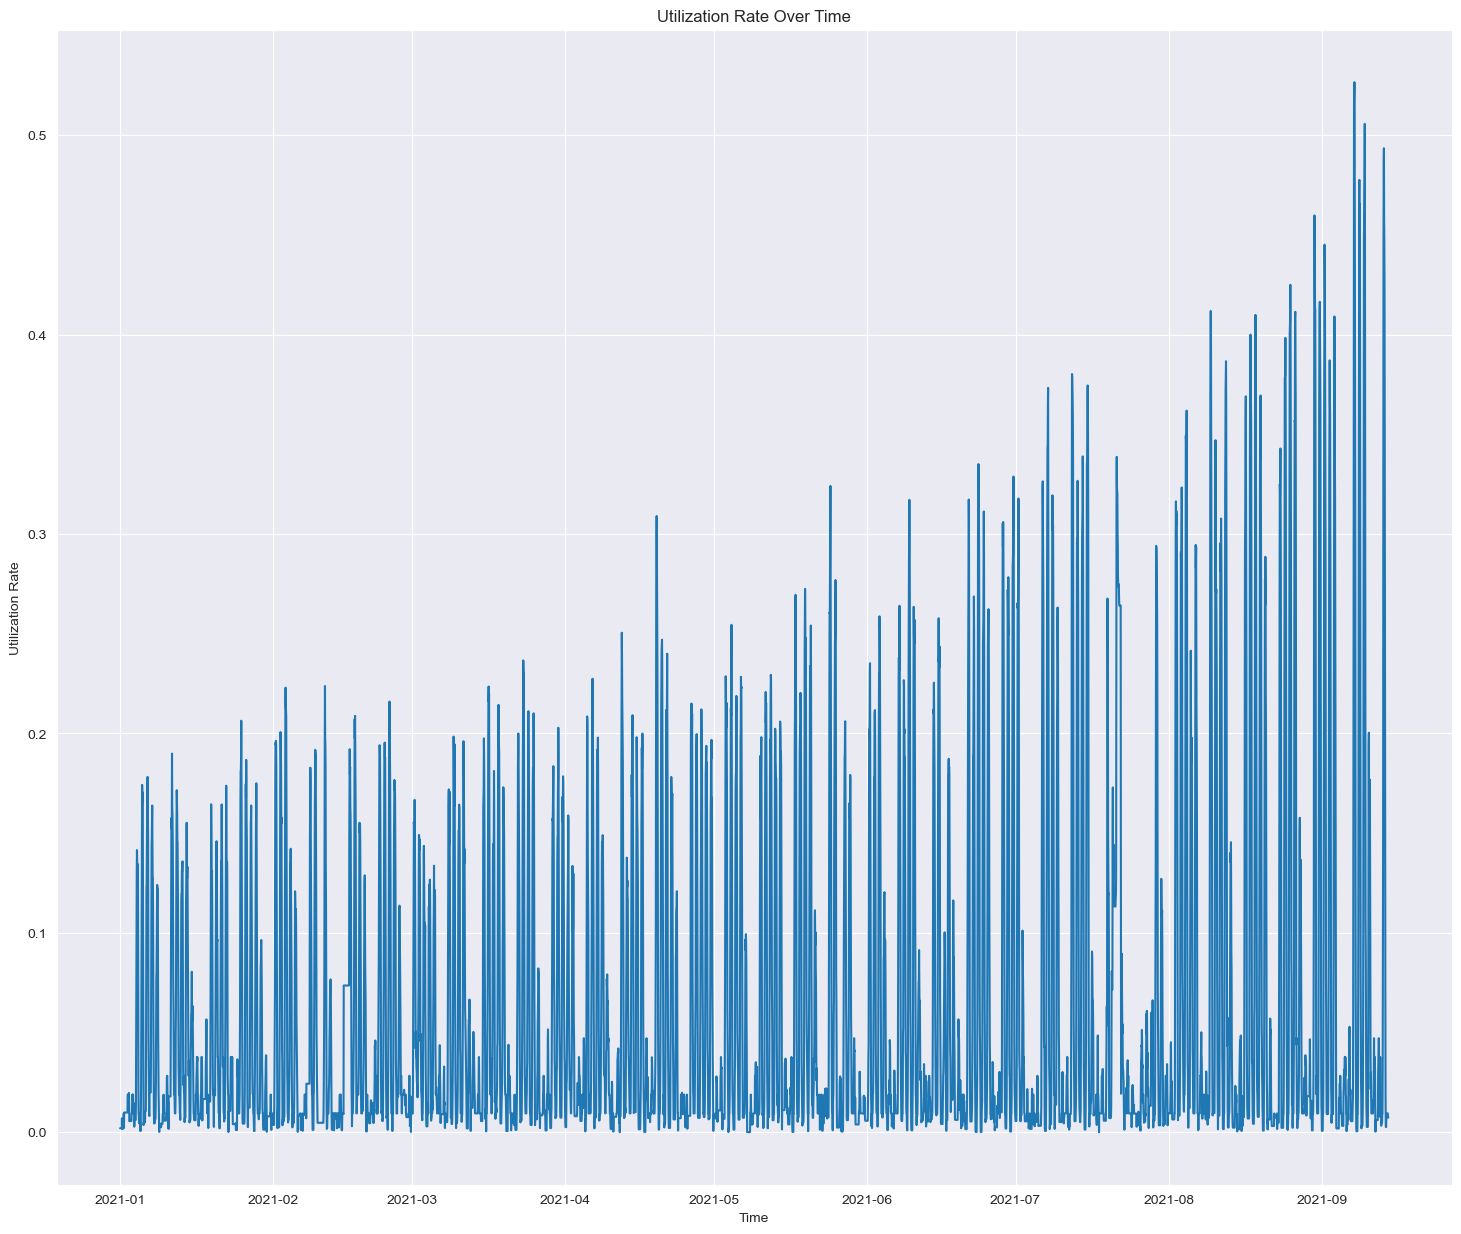

In [4]:
# Load the pickled data
data = pd.read_pickle(os.path.join('..', 'Data', 'aggregated_data.pkl'))

# Select 'utilizationRate_total' column from the DataFrame
data = data[['utilizationRate_total']]  # This keeps it as a DataFrame, not a Series

data.index = pd.to_datetime(data.index)
data = data[data.index.year == 2021]

data.index.freq = 'H'

data['utilizationRate_total'].replace(0, np.nan, inplace=True)
data['utilizationRate_total'].fillna(method='bfill', inplace=True)
data['utilizationRate_total'].fillna(method='ffill', inplace=True)

data.index = pd.to_datetime(data.index).tz_localize(None)

print(data.head())
print(data['utilizationRate_total'].isna().sum())
print(data.shape)
# Plot the DataFrame
plt.figure(figsize=(18, 15))
plt.plot(data)
plt.title('Utilization Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Utilization Rate')
plt.grid(True)
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

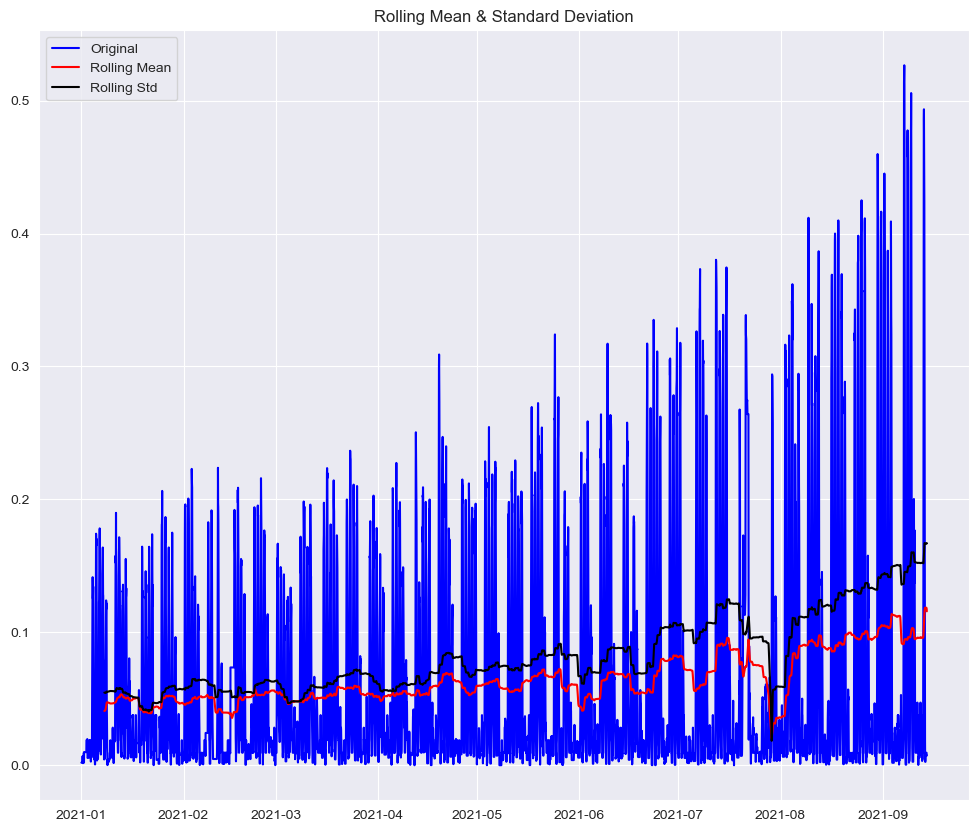

Results of Dickey-Fuller Test:

Test Statistic                -1.014836e+01
p-value                        8.073068e-18
#Lags Used                     3.400000e+01
Number of Observations Used    6.117000e+03
Critical Value (1%)           -3.431419e+00
Critical Value (5%)           -2.862013e+00
Critical Value (10%)          -2.567022e+00
dtype: float64


In [6]:
data = data[data['utilizationRate_total'] != 0]


data.columns = ['utilizationRate_total']
adfuller(data['utilizationRate_total'])
test_stationarity(data['utilizationRate_total'])

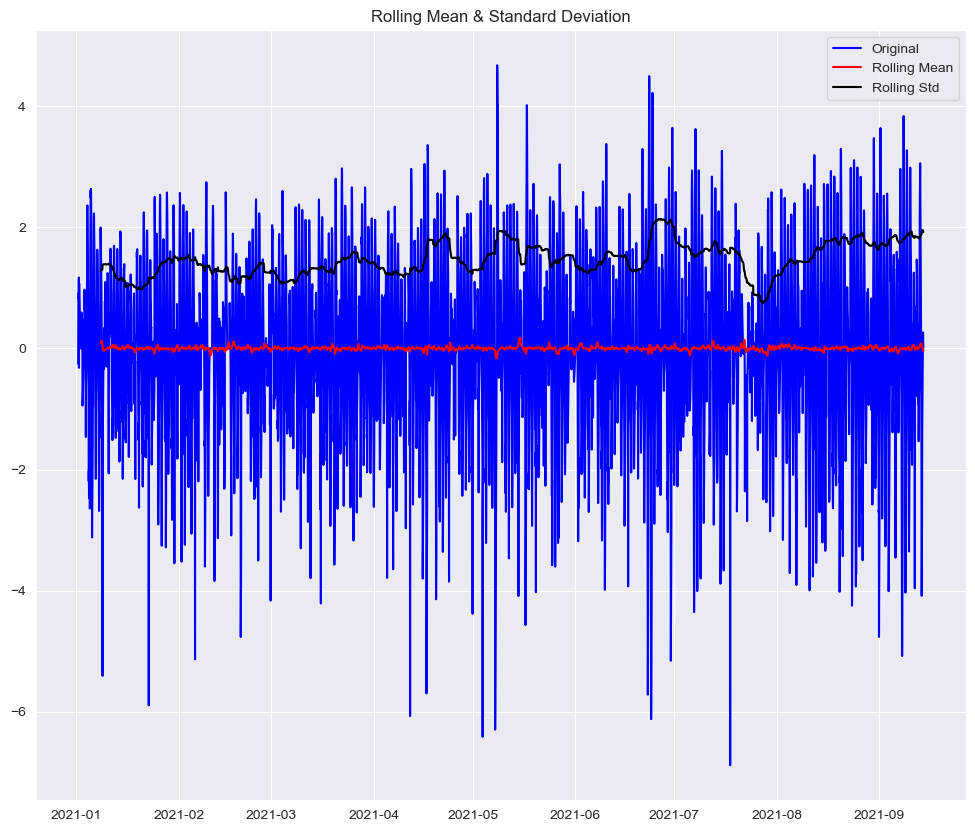

Results of Dickey-Fuller Test:

Test Statistic                -1.662150e+01
p-value                        1.696491e-29
#Lags Used                     3.400000e+01
Number of Observations Used    6.106000e+03
Critical Value (1%)           -3.431421e+00
Critical Value (5%)           -2.862013e+00
Critical Value (10%)          -2.567022e+00
dtype: float64


In [7]:
ts_log = np.log(data['utilizationRate_total'])

moving_avg = ts_log.rolling(12).mean()

ts_log_moving_avg_diff = ts_log - moving_avg

ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

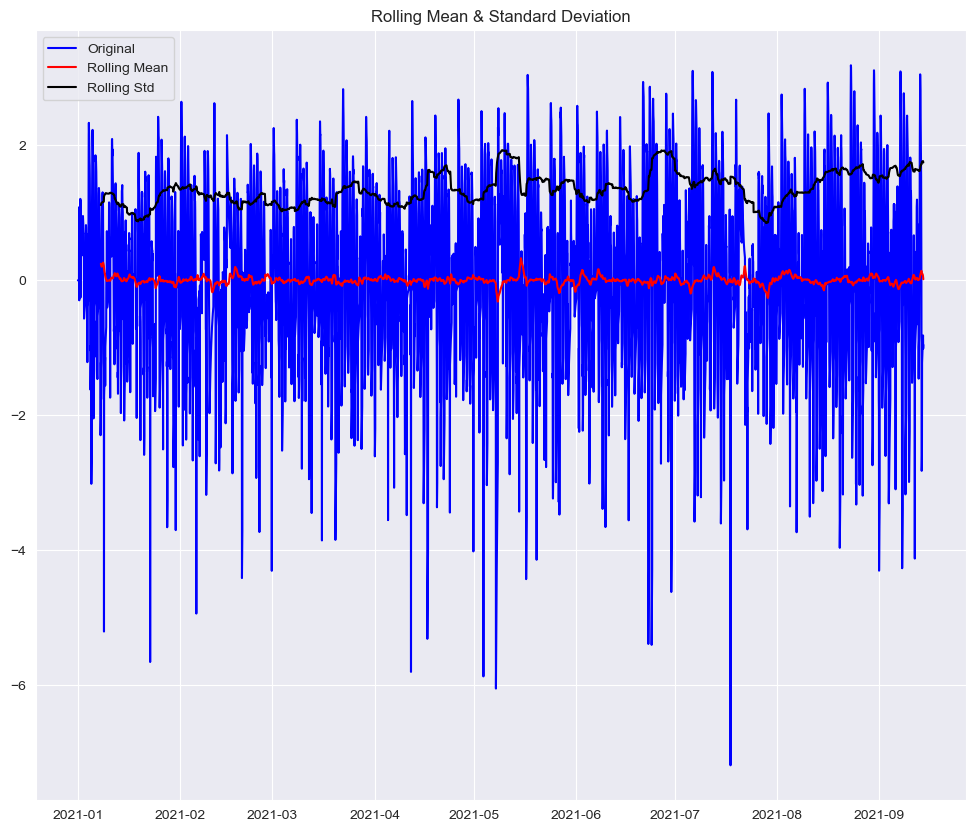

Results of Dickey-Fuller Test:

Test Statistic                -1.373845e+01
p-value                        1.105925e-25
#Lags Used                     3.400000e+01
Number of Observations Used    6.117000e+03
Critical Value (1%)           -3.431419e+00
Critical Value (5%)           -2.862013e+00
Critical Value (10%)          -2.567022e+00
dtype: float64


In [8]:
expwighted_avg=ts_log.ewm(halflife = 12).mean() #Provides exponential weighted functions

ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

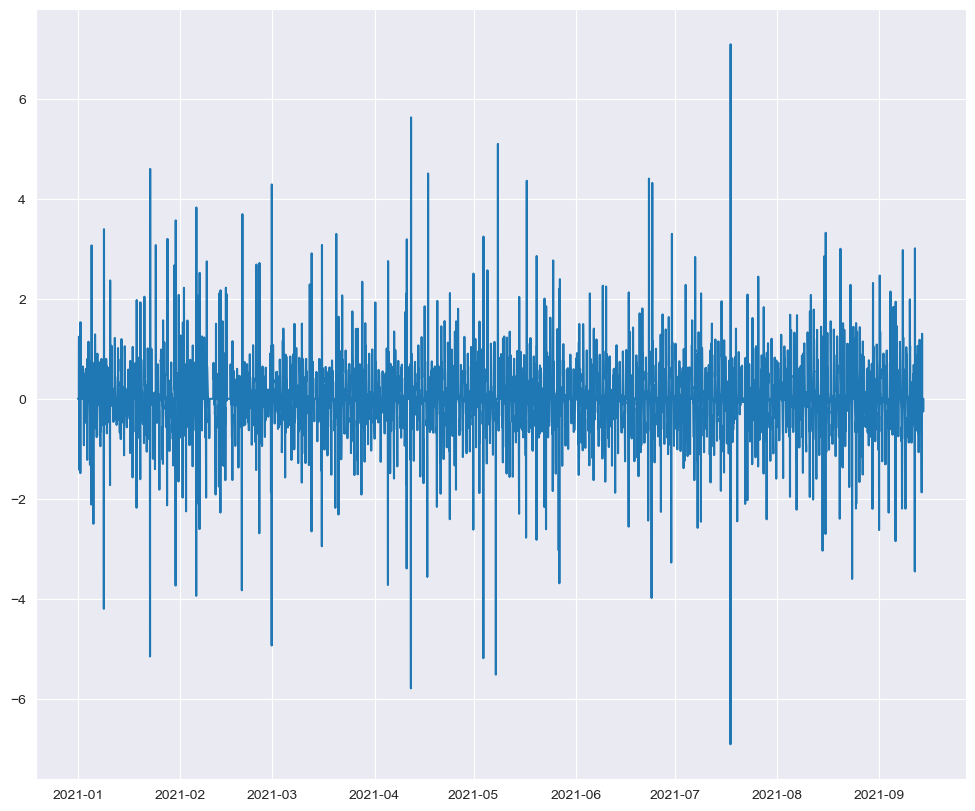

In [9]:
ts_log.shift(periods=1)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

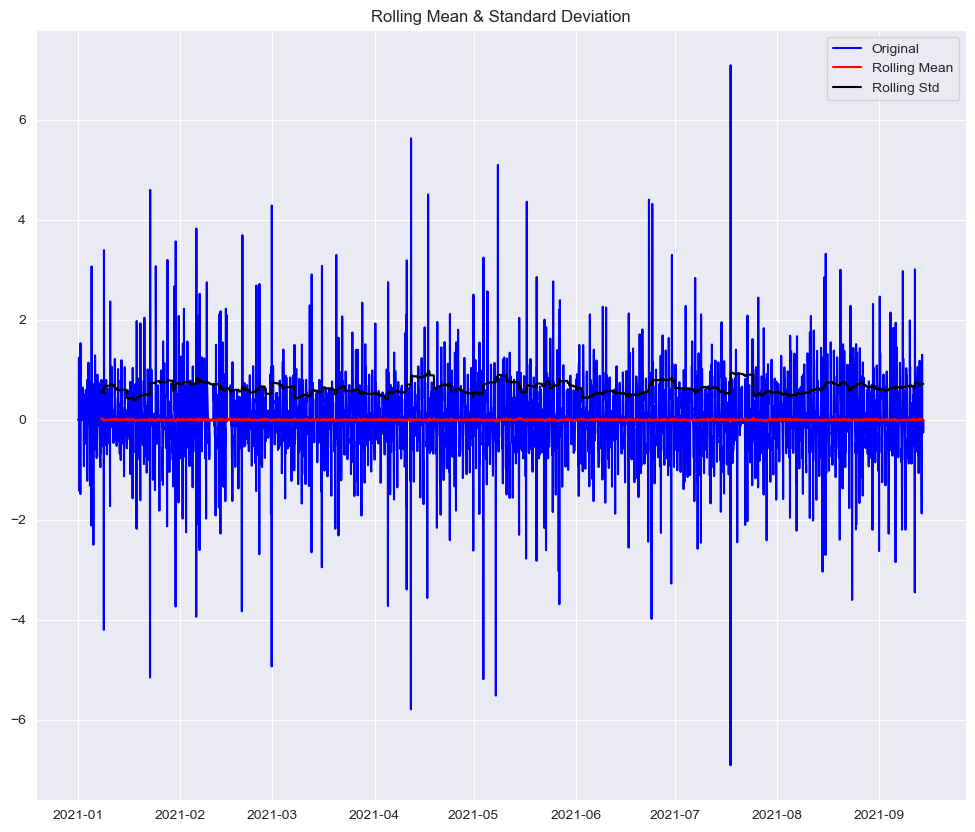

Results of Dickey-Fuller Test:

Test Statistic                -1.769180e+01
p-value                        3.569398e-30
#Lags Used                     3.000000e+01
Number of Observations Used    6.120000e+03
Critical Value (1%)           -3.431419e+00
Critical Value (5%)           -2.862012e+00
Critical Value (10%)          -2.567021e+00
dtype: float64


In [10]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6152 entries, 2021-01-01 00:00:00 to 2021-09-14 08:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   seasonal_24   6152 non-null   float64
 1   seasonal_168  6152 non-null   float64
dtypes: float64(2)
memory usage: 144.2 KB
None


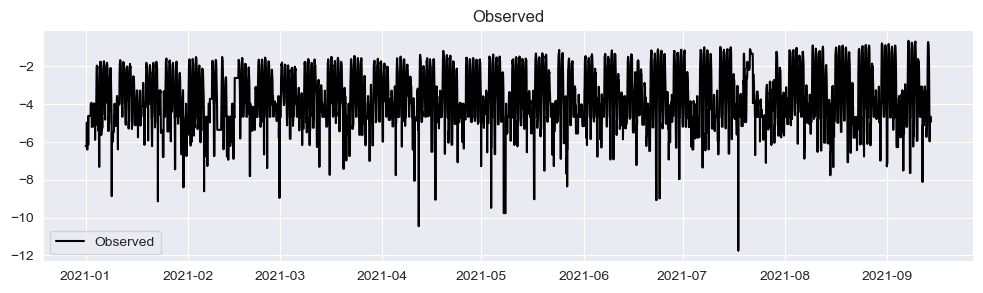

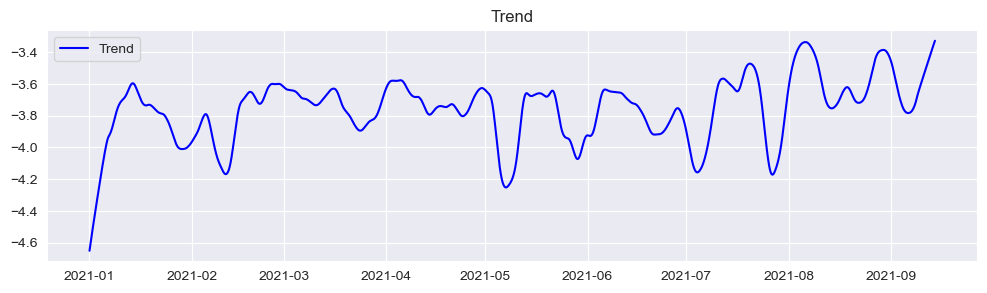

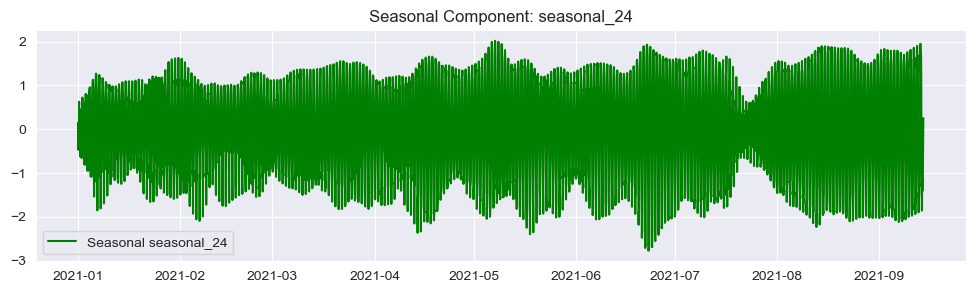

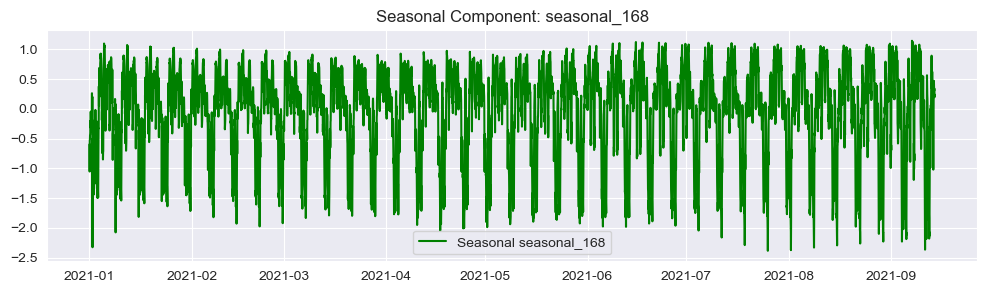

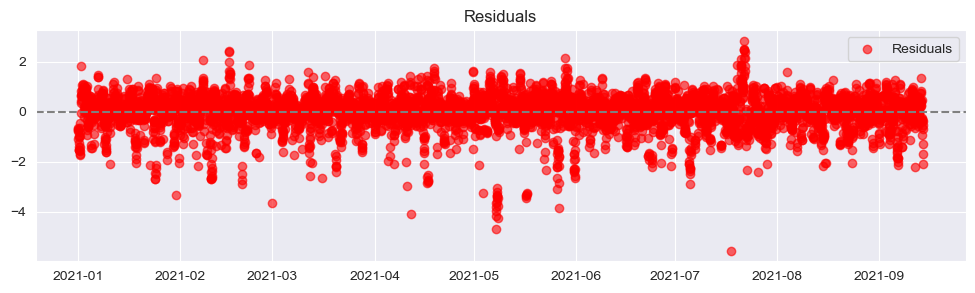

In [11]:
'''
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log) #Seasonal decomposition using moving averages

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
'''

from statsmodels.tsa.seasonal import MSTL

res = MSTL(ts_log, periods=(24, 24*7)).fit()
# Komponenten aus dem res-Objekt extrahieren
observed = res.observed
trend = res.trend
seasonal = res.seasonal
residuals = res.resid
print(seasonal.info())
# Plot für die beobachteten Daten
plt.figure(figsize=(12, 3))
plt.plot(observed, label='Observed', color='black')
plt.title('Observed')
plt.legend()

# Plot für den Trend
plt.figure(figsize=(12, 3))
plt.plot(trend, label='Trend', color='blue')
plt.title('Trend')
plt.legend()

# Plot für jede saisonale Komponente
for col in seasonal.columns:
    plt.figure(figsize=(12, 3))
    plt.plot(seasonal[col], label=f'Seasonal {col}', color='green')
    plt.title(f'Seasonal Component: {col}')
    plt.legend()

# Plot für die Residuen
plt.figure(figsize=(12, 3))
plt.scatter(residuals.index, residuals, label='Residuals', color='red', alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals')
plt.legend()
plt.show()

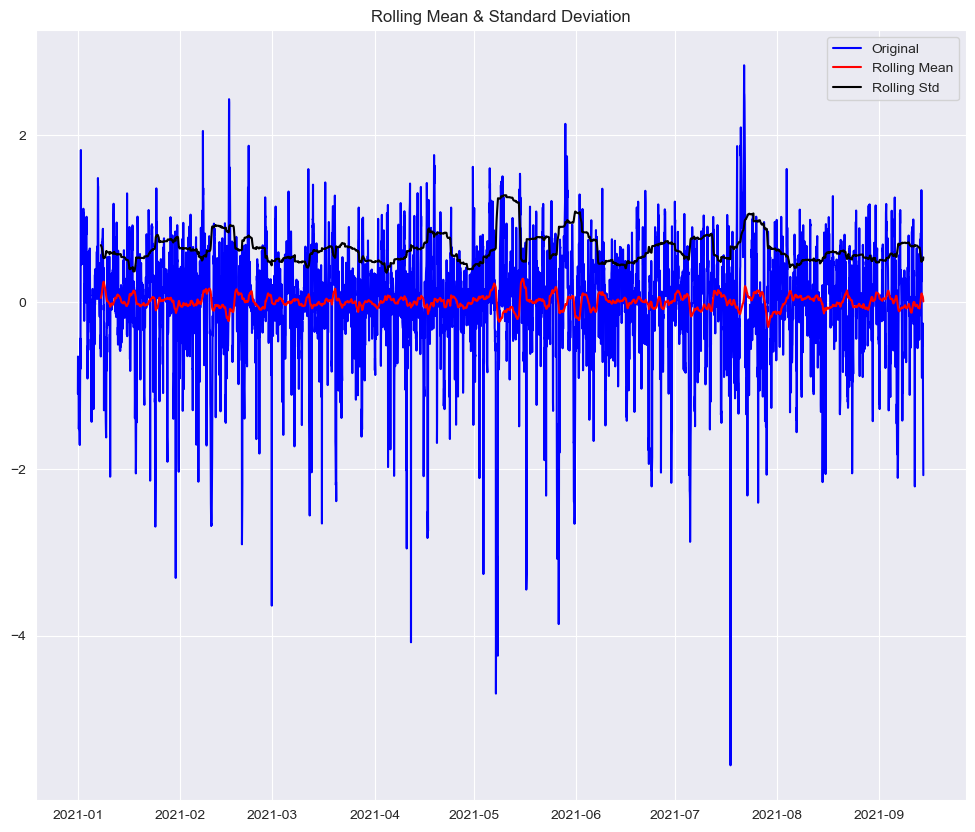

Results of Dickey-Fuller Test:

Test Statistic                -1.558050e+01
p-value                        1.935363e-28
#Lags Used                     2.400000e+01
Number of Observations Used    6.127000e+03
Critical Value (1%)           -3.431418e+00
Critical Value (5%)           -2.862012e+00
Critical Value (10%)          -2.567021e+00
dtype: float64


In [12]:
ts_log_decompose = residuals
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

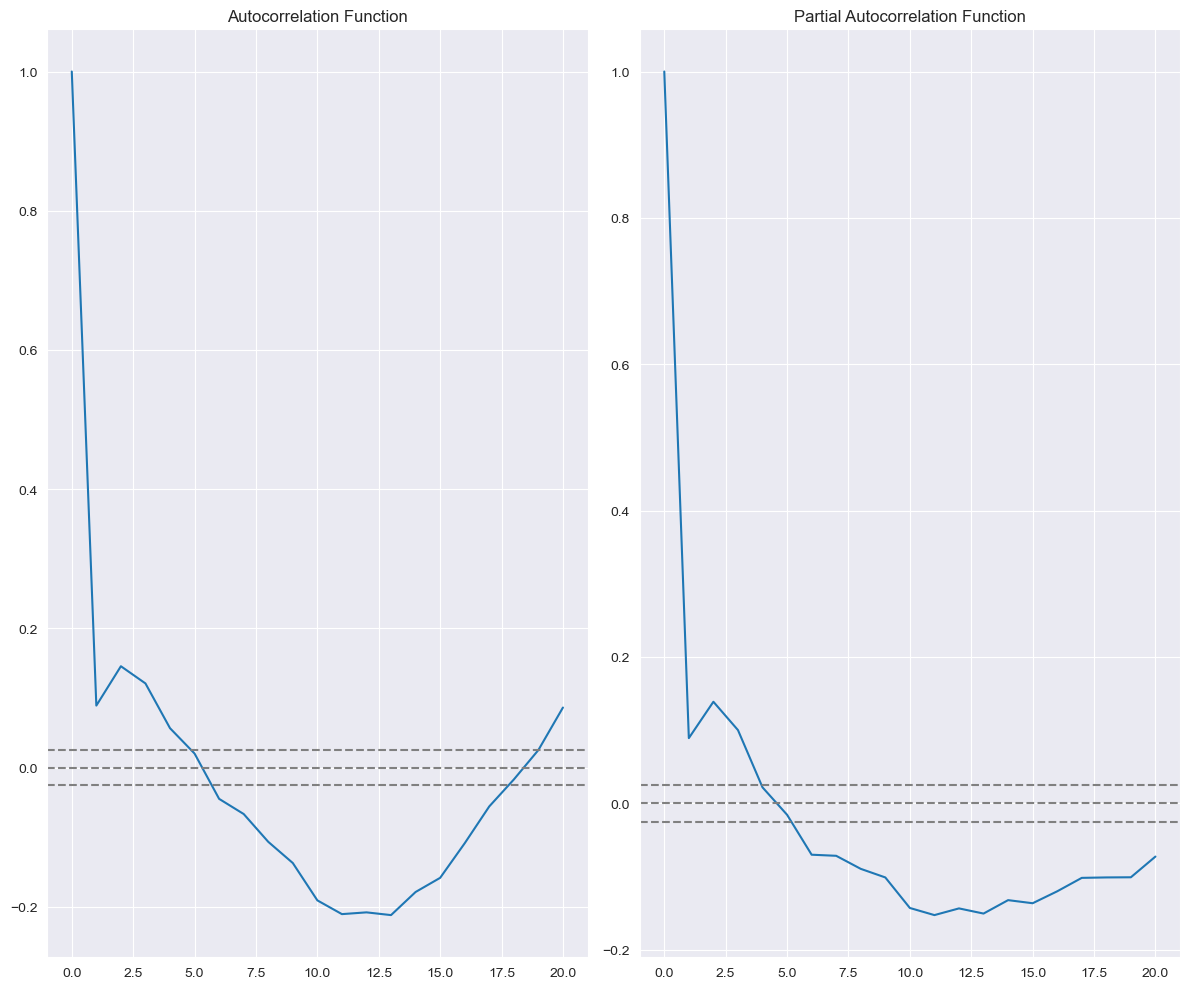

In [13]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/opt/anaconda3/envs/DynamoData/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DynamoData/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DynamoData/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DynamoData/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

Text(0.5, 1.0, 'RSS: 1080.4084')

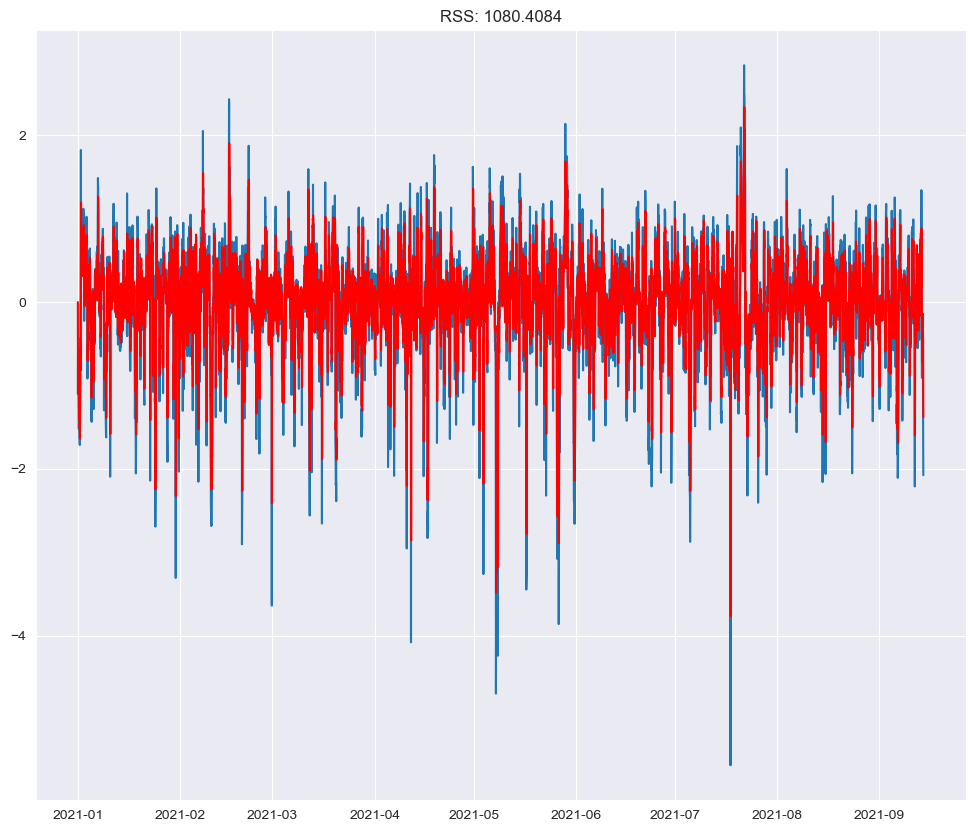

In [14]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# model = auto_arima(ts_log_decompose, trace=True, error_action='ignore', suppress_warnings=True)
# model.summary()
model = ARIMA(ts_log_decompose, order=(4, 1, 5))  
results_ARIMA = model.fit()  
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))

Text(0.5, 1.0, 'RMSE: 5505529564.6101')

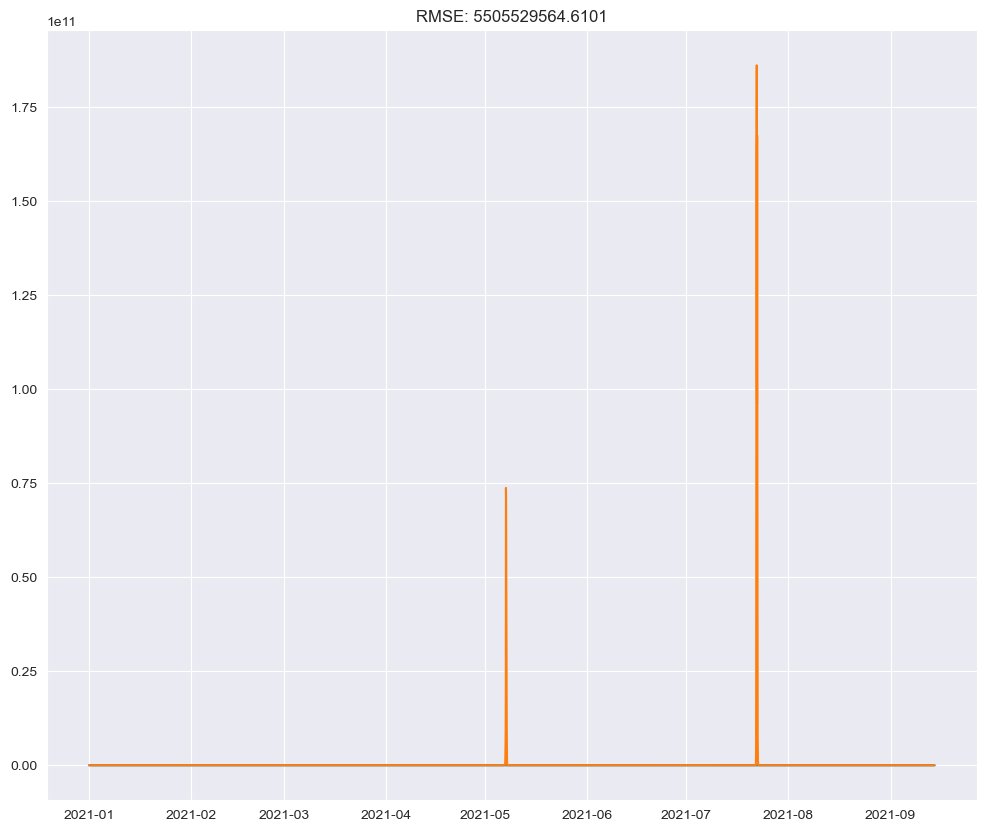

In [15]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

predictions_ARIMA_log = pd.Series(0, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(trend, fill_value=0)
total_seasonal = seasonal['seasonal_24'].add(seasonal['seasonal_168'], fill_value=0)
predictions_ARIMA_log = predictions_ARIMA_log.add(total_seasonal, fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data['utilizationRate_total'])**2)/len(data)))

In [16]:
results_ARIMA.plot_predict(1,264) 



AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'